In [1]:
import numpy as np
import random, time, math
from dataclasses import dataclass, field
from typing import List, Tuple, FrozenSet, Dict, Callable, Optional
from collections import defaultdict, Counter

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import adjusted_rand_score

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True

# Types
Window = FrozenSet[Tuple[int, int]]  # set of (Δt, neuron)


In [2]:
@dataclass
class BenchConfig:
    # Global
    N: int                         # neurons
    D: int                         # window half-width (ms)
    bg_mode: str = "poisson"       # "poisson" or "fixed"
    background_spikes: float = 6.0 # lambda for Poisson or fixed K
    total_negatives: int = 100     # number of negative (background-only) windows

    # Motifs
    M: int = 1                     # number of motifs
    spikes_per_motif: List[int] = field(default_factory=lambda: [5])
    motif_repetitions: List[int] = field(default_factory=lambda: [40])
    focus_neurons: Optional[List[int]] = None  # length M; if None, random distinct neurons

    # Similarity controls
    s_min: int = 0                 # shared-item gate: require ≥ s_min exact matches to consider a pair
                                   # (set >0 to prune candidate pairs; 3 is good for 5-spike motifs)

def make_bg_sampler(mode: str, value: float) -> Callable[[], int]:
    if mode == "poisson":
        lam = float(value)
        return lambda: int(np.random.poisson(lam))
    elif mode == "fixed":
        k = int(round(value))
        return lambda: k
    else:
        raise ValueError("bg_mode must be 'poisson' or 'fixed'")

def _unique_pairs(pairs):
    seen=set(); out=[]
    for p in pairs:
        if p not in seen:
            seen.add(p); out.append(p)
    return out


In [3]:
def make_motif_template(N:int, D:int, k:int, focus:int) -> Window:
    """
    Make one motif with k unique spike items, including the trigger at (0, focus).
    Remaining spikes are sampled uniformly within [-D,D] x [0,N-1].
    """
    k = max(1, k)
    pairs = [(0, focus)]
    while len(pairs) < k:
        dt = np.random.randint(-D, D+1)
        n  = np.random.randint(0, N)
        pairs.append((dt, n))
        pairs = _unique_pairs(pairs)
    return frozenset(sorted(pairs))

def _sample_background_pairs(N:int, D:int, K:int, forbid:Window=frozenset()) -> Window:
    pairs=set(); tries=0
    while len(pairs) < K and tries < K*20:
        dt = np.random.randint(-D, D+1)
        n  = np.random.randint(0, N)
        p=(dt,n)
        if p not in pairs and p not in forbid:
            pairs.add(p)
        tries += 1
    return frozenset(sorted(pairs))

def generate_window_dataset(cfg: BenchConfig):
    """
    Returns:
      windows: list[Window]
      y_true:  np.array of ints (0 = negative; 1..M = motif id)
      meta:    dict with motif templates & bookkeeping
    """
    assert len(cfg.spikes_per_motif) == cfg.M
    assert len(cfg.motif_repetitions) == cfg.M
    if cfg.focus_neurons is None:
        # choose distinct focus neurons if possible
        focuses = list(range(cfg.N))
        random.shuffle(focuses)
        cfg.focus_neurons = focuses[:cfg.M]
    assert len(cfg.focus_neurons) == cfg.M

    bgK = make_bg_sampler(cfg.bg_mode, cfg.background_spikes)

    # Create motifs
    motifs = []
    for m in range(cfg.M):
        motifs.append(make_motif_template(cfg.N, cfg.D, cfg.spikes_per_motif[m], cfg.focus_neurons[m]))

    windows = []
    labels  = []

    # Positives per motif
    for m in range(cfg.M):
        mot = motifs[m]
        reps = cfg.motif_repetitions[m]
        for _ in range(reps):
            k = bgK()
            win = set(mot)
            bg  = _sample_background_pairs(cfg.N, cfg.D, k, forbid=mot)
            win |= set(bg)
            windows.append(frozenset(sorted(win)))
            labels.append(m+1)  # motif ids: 1..M

    # Negatives
    for _ in range(cfg.total_negatives):
        k = bgK()
        neg = _sample_background_pairs(cfg.N, cfg.D, k)
        windows.append(neg)
        labels.append(0)

    y_true = np.array(labels, dtype=int)
    meta = {"motifs": motifs,
            "counts_pos": [int(r) for r in cfg.motif_repetitions],
            "count_neg": cfg.total_negatives}
    return windows, y_true, meta


In [4]:
# --- Similarities ---
def sim_overlap_min(A: Window, B: Window) -> float:
    """ |A∩B| / min(|A|,|B|) """
    if not A or not B: return 0.0
    return len(A.intersection(B)) / min(len(A), len(B))

def sim_jaccard(A: Window, B: Window) -> float:
    """ |A∩B| / |A∪B| """
    if not A and not B: return 0.0
    U = len(A) + len(B) - len(A.intersection(B))
    if U == 0: return 0.0
    return len(A.intersection(B)) / U

def sim_overlap_min_tolerant(A: Window, B: Window, eps:int=1) -> float:
    """
    ε-tolerant greedy 1-1 matching by neuron then Δt within ±eps.
    """
    if not A or not B: return 0.0
    by_n = defaultdict(list)
    for dt, n in B:
        by_n[n].append(dt)
    for n in by_n: by_n[n].sort()
    matched=0
    used=set()
    for dtA, nA in sorted(A):
        arr = by_n.get(nA, [])
        # linear scan is fine (windows are tiny)
        for dtB in arr:
            if abs(dtB-dtA) <= eps and (nA, dtB) not in used:
                used.add((nA, dtB))
                matched += 1
                break
    return matched / min(len(A), len(B))

# --- Candidate pruning via shared-item gate (fast) ---
def find_candidates_by_smin(windows: List[Window], s_min:int) -> Dict[int, Dict[int, int]]:
    """
    Build an inverted index of items -> windows, then count co-occurrences.
    Returns: cand[i][j] = shared_count for j>i with shared_count >= s_min
    If s_min <= 0, returns empty dict (meaning "compute all pairs").
    """
    if s_min <= 0:
        return {}

    item2wins = defaultdict(list)
    for i, W in enumerate(windows):
        for item in W:
            item2wins[item].append(i)

    cand = defaultdict(lambda: defaultdict(int))
    for W in windows:
        pass  # placeholder to allow local var look-up speed-up

    for item, ids in item2wins.items():
        ids = sorted(ids)
        L = len(ids)
        for a in range(L-1):
            i = ids[a]
            for b in range(a+1, L):
                j = ids[b]
                cand[i][j] += 1

    # filter by s_min
    for i in list(cand.keys()):
        for j in list(cand[i].keys()):
            if cand[i][j] < s_min:
                del cand[i][j]
        if not cand[i]:
            del cand[i]
    return cand


In [5]:
def build_similarity_matrix(windows: List[Window],
                            sim_fn: Callable[[Window, Window], float],
                            s_min:int=0):
    """
    Returns:
      S: (n,n) similarity matrix with diagonal zeroed
      build_secs: time in seconds
      pairs_computed: number of pairs actually evaluated
    Uses s_min to skip pairs with < s_min shared items (fast).
    """
    t0 = time.time()
    n = len(windows)
    S = np.zeros((n, n), dtype=float)

    # Candidate pruning
    cand = find_candidates_by_smin(windows, s_min)
    if s_min > 0 and cand:
        # sparse compute on candidates
        pairs = 0
        for i, d in cand.items():
            Wi = windows[i]
            for j, shared in d.items():
                s = sim_fn(Wi, windows[j])
                S[i, j] = S[j, i] = s
                pairs += 1
    else:
        # full dense compute
        pairs = 0
        for i in range(n-1):
            Wi = windows[i]
            for j in range(i+1, n):
                s = sim_fn(Wi, windows[j])
                S[i, j] = S[j, i] = s
                pairs += 1

    # zero diagonal explicitly (as requested)
    np.fill_diagonal(S, 0.0)
    secs = time.time() - t0
    return S, secs, pairs

def condensed_from_similarity(S: np.ndarray) -> np.ndarray:
    """
    Convert S to condensed distance vector for SciPy:
    distance = 1 - similarity
    """
    n = S.shape[0]
    m = n*(n-1)//2
    out = np.empty(m, dtype=float)
    idx = 0
    for i in range(n-1):
        for j in range(i+1, n):
            out[idx] = 1.0 - S[i, j]
            idx += 1
    return out


In [6]:
def collapse_singletons(labels: np.ndarray) -> np.ndarray:
    """
    Map all singleton clusters into a single shared label (e.g., 0),
    then reindex remaining labels to 1..K.
    """
    lab = np.array(labels, dtype=int)
    counts = Counter(lab)
    singleton_ids = {c for c, sz in counts.items() if sz == 1}
    if not singleton_ids:
        return lab

    # map singletons to 0
    lab2 = lab.copy()
    for i, c in enumerate(lab):
        if c in singleton_ids:
            lab2[i] = 0

    # reindex non-zero labels to 1..K keeping order
    uniq = [c for c in sorted(np.unique(lab2)) if c != 0]
    remap = {0: 0}
    for idx, c in enumerate(uniq, start=1):
        remap[c] = idx
    lab3 = np.array([remap[c] for c in lab2], dtype=int)
    return lab3

def pairwise_PRF_same_motif(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[float,float,float]:
    """
    Pairwise precision/recall/F1 computed ONLY on true-positive motif pairs:
    - Positive pair if y_true[i] == y_true[j] > 0 (same motif id)
    - Predicted positive if y_pred[i] == y_pred[j] and y_pred[i] != 0 (ignore singleton group)
    """
    n = len(y_true)
    true_pairs = set()
    for i in range(n-1):
        if y_true[i] == 0: continue
        for j in range(i+1, n):
            if y_true[j] == 0: continue
            if y_true[i] == y_true[j]:
                true_pairs.add((i,j))

    pred_pairs = set()
    for c in np.unique(y_pred):
        if c == 0:  # ignore singleton mega-bin
            continue
        ids = np.where(y_pred == c)[0]
        L = len(ids)
        if L >= 2:
            for a in range(L-1):
                for b in range(a+1, L):
                    i, j = ids[a], ids[b]
                    pred_pairs.add((min(i,j), max(i,j)))

    if len(pred_pairs) == 0:
        precision = 1.0 if len(true_pairs) == 0 else 0.0
    else:
        precision = len(pred_pairs & true_pairs) / len(pred_pairs)

    recall = (len(pred_pairs & true_pairs) / len(true_pairs)) if len(true_pairs) > 0 else 0.0
    f1 = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0.0
    return precision, recall, f1

def clusters_pure_vs_negatives(y_true: np.ndarray, y_pred: np.ndarray) -> bool:
    """
    Returns True if every non-singleton cluster contains zero negatives (label 0).
    """
    for c in np.unique(y_pred):
        if c == 0:  # singleton mega-bin
            continue
        ids = np.where(y_pred == c)[0]
        if len(ids) <= 1:
            continue
        if np.any(y_true[ids] == 0):
            return False
    return True


In [7]:
class DendroLab:
    def __init__(self, S: np.ndarray, method:str="complete"):
        """
        S: similarity matrix (diagonal is zero); builds distance=1-S once.
        """
        t0 = time.time()
        self.S = S
        self.condensed = condensed_from_similarity(S)
        self.link_secs = time.time() - t0

        t1 = time.time()
        self.Z = linkage(self.condensed, method=method)
        self.dendro_secs = time.time() - t1
        self.method = method

    def cut_and_labels(self, thresh: float) -> np.ndarray:
        lab = fcluster(self.Z, thresh, criterion="distance")
        lab = collapse_singletons(lab)  # collapse all singletons into one bin
        return lab

    def sweep(self, thresholds: np.ndarray, y_true: np.ndarray,
              purity_vs_neg: bool = True):
        """
        Evaluate pairwise PRF on motifs; optionally enforce cluster purity vs negatives.
        Returns dict with arrays and best-by-F1 index (under purity constraint if enabled).
        """
        ARI=[]
        PP, RR, FF = [], [], []
        VALID=[]
        BEST = {"idx": None, "f1": -1, "thresh": None, "labels": None}

        for i, t in enumerate(thresholds):
            y_pred = self.cut_and_labels(t)
            ari = adjusted_rand_score(y_true, y_pred)

            p,r,f = pairwise_PRF_same_motif(y_true, y_pred)
            valid = clusters_pure_vs_negatives(y_true, y_pred) if purity_vs_neg else True

            ARI.append(ari); PP.append(p); RR.append(r); FF.append(f); VALID.append(valid)

            if valid and f > BEST["f1"]:
                BEST = {"idx": i, "f1": f, "thresh": t, "labels": y_pred}

        return {
            "thresholds": thresholds,
            "ari": np.array(ARI),
            "precision": np.array(PP),
            "recall": np.array(RR),
            "f1": np.array(FF),
            "valid": np.array(VALID, dtype=bool),
            "best": BEST
        }


In [8]:
class GraphLab:
    @staticmethod
    def conn_components_from_threshold(S: np.ndarray, tau: float) -> np.ndarray:
        """
        Undirected graph with edges where S >= tau (off-diagonal),
        then connected components. Singletons collapsed automatically
        when returned labels are remapped below.
        """
        n = S.shape[0]
        parent = list(range(n))
        rank = [0]*n
        def find(x):
            while parent[x]!=x:
                parent[x]=parent[parent[x]]
                x=parent[x]
            return x
        def union(x,y):
            rx, ry = find(x), find(y)
            if rx==ry: return
            if rank[rx]<rank[ry]: parent[rx]=ry
            elif rank[rx]>rank[ry]: parent[ry]=rx
            else: parent[ry]=rx; rank[rx]+=1

        for i in range(n-1):
            for j in range(i+1, n):
                if S[i,j] >= tau:
                    union(i,j)

        roots = [find(i) for i in range(n)]
        # map roots to compact labels
        uniq = {}
        lab = np.zeros(n, dtype=int)
        next_id = 1
        for i, r in enumerate(roots):
            if r not in uniq:
                uniq[r] = next_id
                next_id += 1
            lab[i] = uniq[r]

        # collapse singletons to 0
        lab2 = collapse_singletons(lab)
        return lab2

    @staticmethod
    def conn_components_from_knn(S: np.ndarray, k: int, tau: float=0.0) -> np.ndarray:
        """
        k-NN graph (union, not mutual): connect i to top-k neighbors with S>=tau.
        Then connected components. Collapse singletons.
        """
        n = S.shape[0]
        parent = list(range(n))
        rank = [0]*n
        def find(x):
            while parent[x]!=x:
                parent[x]=parent[parent[x]]
                x=parent[x]
            return x
        def union(x,y):
            rx, ry = find(x), find(y)
            if rx==ry: return
            if rank[rx]<rank[ry]: parent[rx]=ry
            elif rank[rx]>rank[ry]: parent[ry]=rx
            else: parent[ry]=rx; rank[rx]+=1

        for i in range(n):
            # exclude self, get top-k
            idx = np.argsort(S[i])[::-1]
            idx = [j for j in idx if j != i and S[i,j] >= tau][:k]
            for j in idx:
                union(i,j)

        roots = [find(i) for i in range(n)]
        uniq = {}
        lab = np.zeros(n, dtype=int)
        next_id = 1
        for i, r in enumerate(roots):
            if r not in uniq:
                uniq[r] = next_id
                next_id += 1
            lab[i] = uniq[r]
        lab2 = collapse_singletons(lab)
        return lab2


In [9]:
def plot_dendrogram(Z, cut: Optional[float]=None, title:str="Dendrogram"):
    plt.figure(figsize=(8, 3))
    dendrogram(Z, no_labels=True, count_sort=True)
    if cut is not None:
        plt.axhline(cut, color="r", linestyle="--", alpha=0.7)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def leaf_order_from_Z(Z) -> List[int]:
    dd = dendrogram(Z, no_plot=True)
    return dd["leaves"]

def plot_similarity_heatmap(S: np.ndarray, order: Optional[List[int]]=None, title:str="Similarity (reordered)"):
    if order is None:
        order = list(range(S.shape[0]))
    S_re = S[np.ix_(order, order)]
    plt.figure(figsize=(5.2,4.6))
    im = plt.imshow(S_re, interpolation="nearest", aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def show_cluster_sizes(labels: np.ndarray, label=""):
    sizes = sorted(Counter(labels).values(), reverse=True)
    print(f"{label} cluster sizes (top 10):", sizes[:10], "| #clusters:", len(set(labels)))


In [96]:
# Example config with M motifs (each parameter is a list of length M)
N,D = 100, 50
Hz = 3
cfg = BenchConfig(
    N=N,
    D=D,
    bg_mode="poisson",
    background_spikes=(2*Hz/1000)*N*D,
    total_negatives=100,
    M=1,
    spikes_per_motif=[5],
    motif_repetitions=[5],
    focus_neurons=[0],   # can set None to randomize
    s_min=3                 # shared-item gate (try 0, 2, 3)
)

windows, y_true, meta = generate_window_dataset(cfg)
print("Motif sizes:", [len(m) for m in meta["motifs"]])
print("Positives per motif:", meta["counts_pos"], "| Negatives:", meta["count_neg"])
print("Total windows:", len(windows))


Motif sizes: [5]
Positives per motif: [5] | Negatives: 100
Total windows: 105


In [97]:
list(meta['motifs'][0])

[(4, 19), (-36, 75), (0, 0), (-30, 61), (2, 95)]

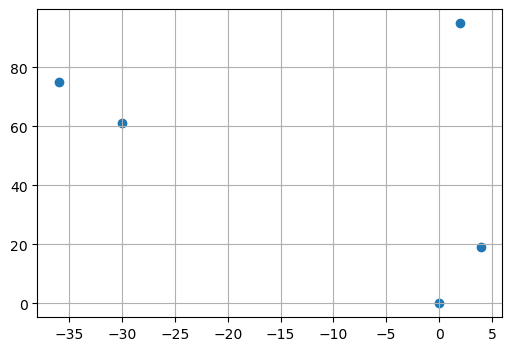

In [98]:
plt.figure()
plt.scatter(*np.array(list(meta['motifs'][0])).T)
plt.show()

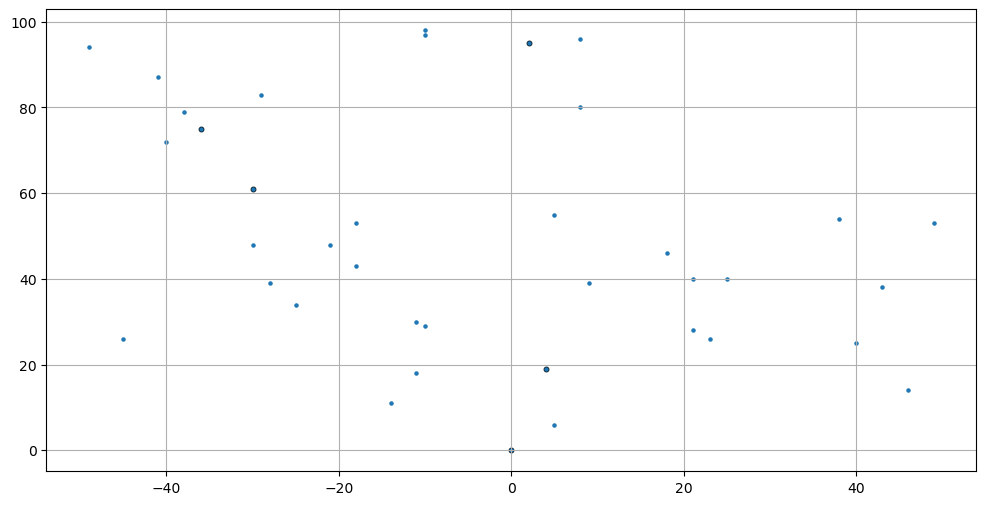

In [99]:
plt.figure(figsize=(12,6))
plt.scatter(*np.array(list(meta['motifs'][0])).T,color='black',s=10)
# plt.scatter(*np.array(list(windows[0])).T,s=5,alpha=0.99,color='red')
plt.scatter(*np.array(list(windows[1])).T,s=5,alpha=0.99)
# plt.scatter(*np.array(list(windows[2])).T,s=5,marker='|',alpha=0.99)
# plt.scatter(*np.array(list(windows[3])).T,s=5,marker='|',alpha=0.99)
# plt.scatter(*np.array(list(windows[4])).T,s=5,marker='|',alpha=0.99)
plt.show()

In [100]:
# Choose similarity; start with exact overlap-min
SIM_FN = sim_overlap_min
S, sim_secs, pairs_computed = build_similarity_matrix(windows, SIM_FN, s_min=cfg.s_min)
print(f"S built in {sim_secs:.3f}s | pairs computed: {pairs_computed} / {len(windows)*(len(windows)-1)//2}")

lab = DendroLab(S, method="complete")  # try "average" later if positives fragment
print(f"condensed build: ~0s | linkage: {lab.dendro_secs:.3f}s (method={lab.method})")

# Threshold grid (higher cuts merge more)
thresholds = np.linspace(0,5,101)
res = lab.sweep(thresholds, y_true, purity_vs_neg=True)

print("Best by F1 (under purity vs negatives):", res["best"])
if res["best"]["labels"] is not None:
    show_cluster_sizes(res["best"]["labels"], "Best-cut")


S built in 0.003s | pairs computed: 11 / 5460
condensed build: ~0s | linkage: 0.000s (method=complete)
Best by F1 (under purity vs negatives): {'idx': 17, 'f1': 0.7499999999999999, 'thresh': np.float64(0.8500000000000001), 'labels': array([1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}
Best-cut cluster sizes (top 10): [101, 4] | #clusters: 2


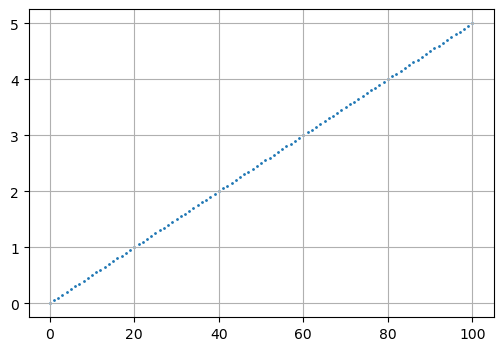

In [101]:
plt.figure()
plt.scatter(np.arange(len(thresholds)),thresholds,s=1)
plt.show()

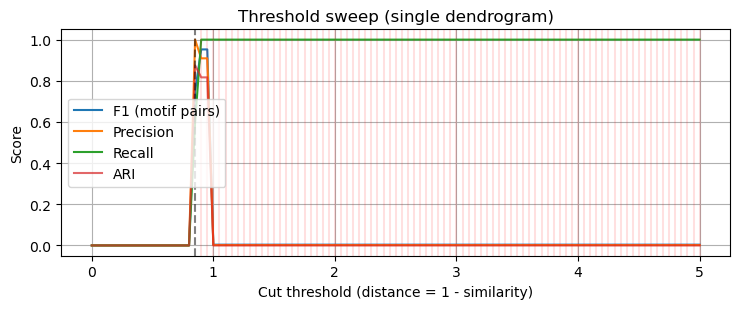

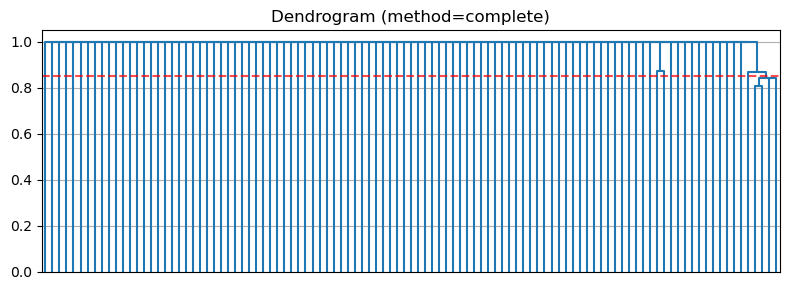

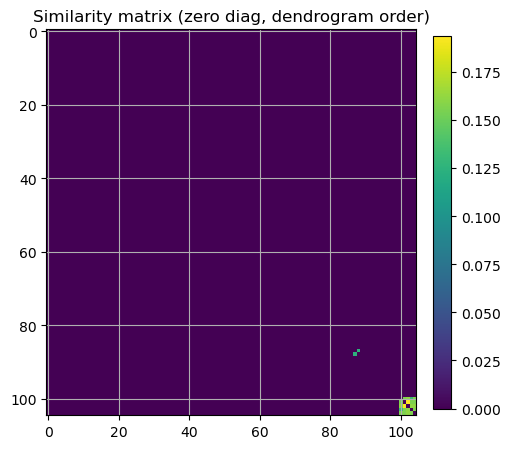

In [102]:
# Metrics vs threshold
plt.figure(figsize=(7.5,3.2))
plt.plot(res["thresholds"], res["f1"], label="F1 (motif pairs)")
plt.plot(res["thresholds"], res["precision"], label="Precision")
plt.plot(res["thresholds"], res["recall"], label="Recall")
plt.plot(res["thresholds"], res["ari"], label="ARI", alpha=0.7)
if res["best"]["thresh"] is not None:
    plt.axvline(res["best"]["thresh"], color="k", linestyle="--", alpha=0.5)
# mark invalid cuts
for t,v in zip(res["thresholds"], res["valid"]):
    if not v:
        plt.axvline(t, color="r", alpha=0.12)
plt.xlabel("Cut threshold (distance = 1 - similarity)")
plt.ylabel("Score")
plt.title("Threshold sweep (single dendrogram)")
plt.legend()
plt.tight_layout()
plt.show()

# Dendrogram + cut
plot_dendrogram(lab.Z, cut=res["best"]["thresh"] if res["best"]["thresh"] else None,
                title=f"Dendrogram (method={lab.method})")

# Heatmap reordered by dendrogram leaf order
order = leaf_order_from_Z(lab.Z)
plot_similarity_heatmap(S, order, title="Similarity matrix (zero diag, dendrogram order)")


In [103]:
# Thresholded graph components
tau = 0.45  # similarity threshold; tune by viewing heatmap & size hist.
y_thr = GraphLab.conn_components_from_threshold(S, tau)
show_cluster_sizes(y_thr, f"Graph τ={tau}")
p,r,f = pairwise_PRF_same_motif(y_true, y_thr)
print(f"Graph τ={tau} | Precision={p:.3f} Recall={r:.3f} F1={f:.3f} | Pure vs neg:", clusters_pure_vs_negatives(y_true, y_thr))

# k-NN components
k = 5; tau_knn = 0.0  # keep tau_knn>0 to enforce strength
y_knn = GraphLab.conn_components_from_knn(S, k=k, tau=tau_knn)
show_cluster_sizes(y_knn, f"kNN k={k}, τ={tau_knn}")
p2,r2,f2 = pairwise_PRF_same_motif(y_true, y_knn)
print(f"kNN k={k}, τ={tau_knn} | Precision={p2:.3f} Recall={r2:.3f} F1={f2:.3f} | Pure vs neg:", clusters_pure_vs_negatives(y_true, y_knn))

# Compare best dendro vs graphs quickly
if res["best"]["labels"] is not None:
    pD,rD,fD = pairwise_PRF_same_motif(y_true, res["best"]["labels"])
    print(f"\nBest dendro | Prec={pD:.3f} Rec={rD:.3f} F1={fD:.3f}")
    print(f"Graph τ={tau} | Prec={p:.3f} Rec={r:.3f} F1={f:.3f}")
    print(f"kNN  k={k}   | Prec={p2:.3f} Rec={r2:.3f} F1={f2:.3f}")


Graph τ=0.45 cluster sizes (top 10): [105] | #clusters: 1
Graph τ=0.45 | Precision=0.000 Recall=0.000 F1=0.000 | Pure vs neg: True
kNN k=5, τ=0.0 cluster sizes (top 10): [105] | #clusters: 1
kNN k=5, τ=0.0 | Precision=0.002 Recall=1.000 F1=0.004 | Pure vs neg: False

Best dendro | Prec=1.000 Rec=0.600 F1=0.750
Graph τ=0.45 | Prec=0.000 Rec=0.000 F1=0.000
kNN  k=5   | Prec=0.002 Rec=1.000 F1=0.004
